In [4]:
import tifffile
import numpy as np

print(tifffile.__version__)
print(np.__version__)

2020.6.3
1.24.4


In [7]:
import numpy as np

def extract_mean_frame(data: np.ndarray,
                       num_v: int,
                       num_s: int,
                       num_f: int,
                       *, dtype=np.float32,
                       check=True) -> np.ndarray:
    """
    Average across ALL volumes and frames.
    Output: one mean image per stack/plane.

    Assumed order (fastest -> slowest):
        frame -> stack -> volume

    Parameters
    ----------
    data : ndarray
        Shape (T, Y, X)
    num_v : int
        Number of volumes
    num_s : int
        Number of stacks / planes
    num_f : int
        Frames per plane
    dtype : dtype
        Accumulation dtype
    check : bool
        Validate frame count

    Returns
    -------
    mean_frames : ndarray
        Shape (num_s, Y, X)
    """
    if data.ndim != 3:
        raise ValueError(f"Expected (T,Y,X), got {data.shape}")

    T, Y, X = data.shape
    expected = num_v * num_s * num_f
    if check and T != expected:
        raise ValueError(
            f"Frame mismatch: T={T}, expected {expected} "
            f"(num_v={num_v}, num_s={num_s}, num_f={num_f})"
        )

    # (T,Y,X) → (V,S,F,Y,X)
    data = data.astype(dtype, copy=False)
    reshaped = data.reshape(num_v, num_s, num_f, Y, X)

    # average over volume and frame
    mean_frames = reshaped.mean(axis=(0, 2))  # (S,Y,X)

    return mean_frames


In [8]:
# read a tiff file and plot the images

path = r"C:\Users\BurgessLab\Desktop\SM2PCode\2D2P\Data\stack27072023_00002.tif"

# path = r"D:\data\724\08112024_session_00002.tif"

data = tifffile.imread(path)

print("shape:", data.shape)
print("dtype:", data.dtype)

num_v = 1
num_s = 21
num_f = 200


mean_frames = extract_mean_frame(data, num_v, num_s, num_f, dtype=np.float32, check=True)

mean_frames.shape


shape: (4200, 512, 512)
dtype: int16


(21, 512, 512)

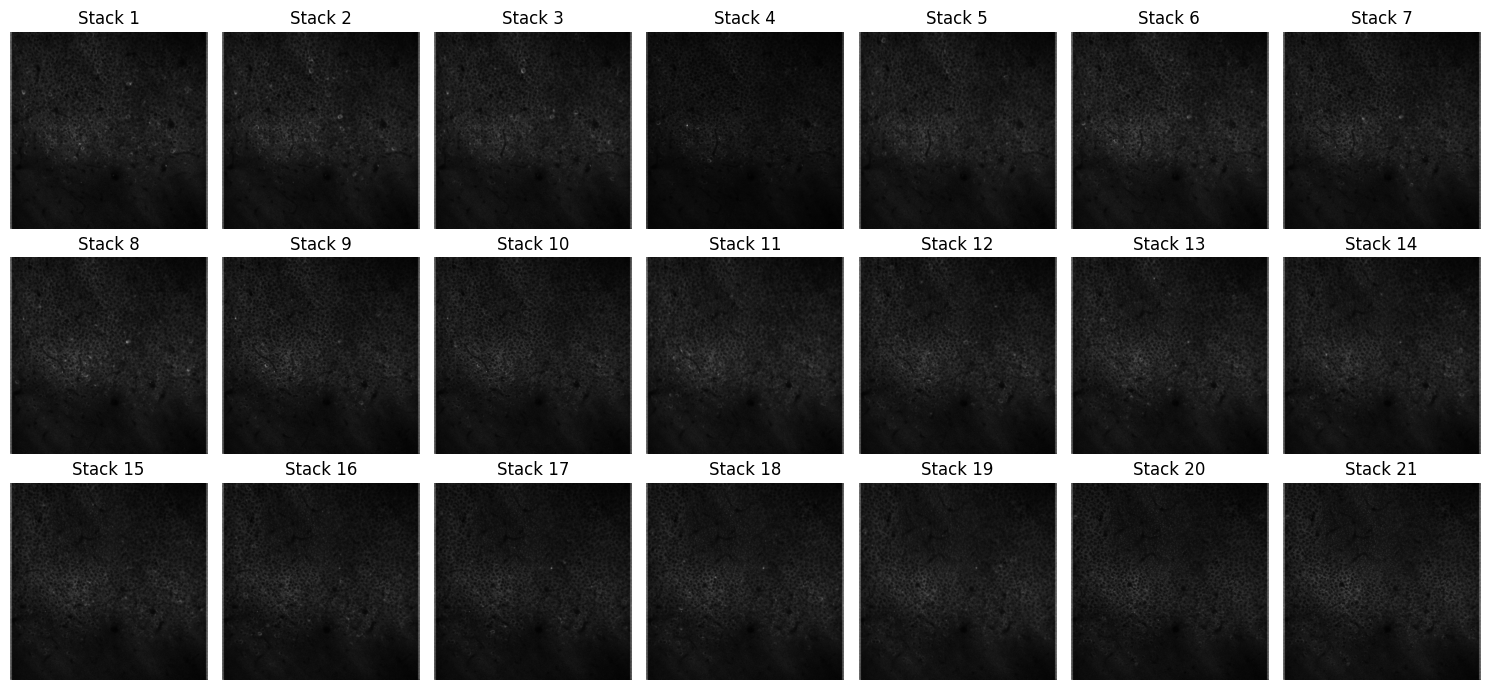

In [9]:
import matplotlib.pyplot as plt
#show 21 mean frames in a 3x7 grid
fig, axes = plt.subplots(3, 7, figsize=(15, 7))
for i, ax in enumerate(axes.flat):
    if i < mean_frames.shape[0]:
        ax.imshow(mean_frames[i], cmap='gray')
        ax.set_title(f'Stack {i+1}')
    ax.axis('off')
plt.tight_layout()

In [10]:
import tifffile

with tifffile.TiffFile(r"C:\Users\BurgessLab\Desktop\SM2PCode\2D2P\Data\stack27072023_00002.tif") as tif:
    dt = tif.pages[0].tags.get("DateTime")
    print(dt.value if dt else None)


None


In [12]:
with tifffile.TiffFile(r"C:\Users\BurgessLab\Desktop\SM2PCode\2D2P\Data\stack27072023_00002.tif") as tif:
    desc = tif.pages[0].description
    print(desc[:8000])   # 先看前 2000 个字符

frameNumbers = 1
acquisitionNumbers = 1
frameNumberAcquisition = 1
frameTimestamps_sec = 0.000000000
acqTriggerTimestamps_sec = -0.000063750
nextFileMarkerTimestamps_sec = -1.000000000
endOfAcquisition = 0
endOfAcquisitionMode = 0
dcOverVoltage = 0
epoch = [2023  7 27 16  9 18.354]
auxTrigger0 = []
auxTrigger1 = []
auxTrigger2 = []
auxTrigger3 = []
I2CData = {}


In [13]:
import numpy as np
import tifffile

def get_frame_timestamps_sec(path: str) -> np.ndarray:
    """
    Return per-frame timestamps in seconds relative to acquisition epoch.
    Works if ScanImage stored per-frame metadata.
    """
    with tifffile.TiffFile(path) as tif:
        ts = []
        for page in tif.pages:
            md = page.scanimage_metadata  # dict (if present)
            if md is None or "frameTimestamps_sec" not in md:
                raise ValueError("This TIFF page has no scanimage frameTimestamps_sec.")
            ts.append(float(md["frameTimestamps_sec"]))
    return np.asarray(ts, dtype=np.float64)

path = r"C:\Users\BurgessLab\Desktop\SM2PCode\2D2P\Data\stack27072023_00002.tif"
ts = get_frame_timestamps_sec(path)

print("N frames:", ts.size)
print("first 10 (sec):", ts[:10])
print("last 10 (sec):", ts[-10:])
print("dt first 10 (sec):", np.diff(ts[:11]))


AttributeError: 'TiffPage' object has no attribute 'scanimage_metadata'

In [17]:
import re
import numpy as np
import tifffile

_epoch_re = re.compile(
    r"epoch\s*=\s*\[\s*(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+([0-9]*\.?[0-9]+)\s*\]"
)
_ts_re = re.compile(
    r"frameTimestamps_sec\s*=\s*([-+]?[0-9]*\.?[0-9]+)"
)

def extract_frame_timestamps_from_descriptions(path: str, *, max_pages=None):
    """
    Extract per-frame frameTimestamps_sec (relative seconds) from each page's description.
    Also returns epoch from the first page where it's found.

    Returns
    -------
    ts_sec : (T,) float64
    epoch  : tuple(Y,M,D,H,Min,SecFloat) or None
    """
    ts = []
    epoch = None

    with tifffile.TiffFile(path) as tif:
        pages = tif.pages
        n = len(pages) if max_pages is None else min(len(pages), int(max_pages))

        for i in range(n):
            desc = pages[i].description or ""
            m = _ts_re.search(desc)
            if not m:
                raise ValueError(f"Page {i} has no frameTimestamps_sec in description.")
            ts.append(float(m.group(1)))

            if epoch is None:
                me = _epoch_re.search(desc)
                if me:
                    Y, Mo, D, H, Mi, S = me.groups()
                    epoch = (int(Y), int(Mo), int(D), int(H), int(Mi), float(S))

    return np.asarray(ts, dtype=np.float64), epoch

# ---- use it ----
path = r"C:\Users\BurgessLab\Desktop\SM2PCode\2D2P\Data\stack27072023_00002.tif"
ts_sec, epoch = extract_frame_timestamps_from_descriptions(path)

print("N frames:", ts_sec.size)
print("first 10 t(sec):", ts_sec[:10])
print("epoch:", epoch)
print("dt first 10 (sec):", np.diff(ts_sec[:11]))


N frames: 4200
first 10 t(sec): [0.         0.03334415 0.06668835 0.10003255 0.13337675 0.16672095
 0.20006515 0.2334094  0.26675365 0.3000979 ]
epoch: (2023, 7, 27, 16, 9, 18.354)
dt first 10 (sec): [0.03334415 0.0333442  0.0333442  0.0333442  0.0333442  0.0333442
 0.03334425 0.03334425 0.03334425 0.03334425]


In [16]:
with tifffile.TiffFile(path) as tif:
    print(type(tif.scanimage_metadata))
    if isinstance(tif.scanimage_metadata, dict):
        print("keys:", tif.scanimage_metadata.keys())


<class 'dict'>
keys: dict_keys(['Description'])
